## Machine Learning in Finance
## Group Project
* This is a group project due on 08/01/2026
* Groups should have 3-5 members each.
* All projects should be completed using Jupyter notebooks which will be delivered at the end of the project. Each task should have an independent jupyter notebook, to assist in the grading.
* Please read the instructions as you also need to deliver a video.

### Project Context
Home Credit is a financial services company that provides loans to customers often underserved by traditional banking institutions. The goal is to use machine learning to assess the risk of default at the loan application stage, enabling better decision-making and optimized loan offerings. Understanding which customers are likely to default is crucial for reducing financial losses and improving operational efficiency.

### Project data
You have access to the Home Credit Default Risk dataset, along with a data dictionary to help you understand the column titles. However, you will need to explore the data yourself—not all columns will be useful, and some may require significant preprocessing. Your tasks will include:
* Cleaning the data (e.g., handling null values, resolving data type issues, addressing outliers).
* Dealing with categorical variables and feature engineering.
* Exploring which features are useful for predictive tasks and avoiding features that may leak data.

### Computation
Dealing with computation constraints is a big part of machine learning, especially as we start to deal with real world data. If at any point you are trying to run an algorithm or approach that is taking a long time to solve on google colab you have a couple of options:
* You can try running it on your laptop directly, in case your laptop or computer is faster.
* You can try to reduce the complexity of the model.
* You can reduce the complexity of the data by reducing the number of columns you use at a time.
* You can just take a smaller sample of the data (less rows) and apply the algorithm / model to this.

#### Grading
* Important you will mostly be graded on your ability to apply the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.
* You might receive extra points for demonstrating the ability to apply approaches not covered in the class.
* What your final model is (and how well it performs) matters much less than your ability to correctly apply different approaches, explore the problem, and understand the final results and model. Please try to demonstrate in the notebooks and the video.
* Well organized Jupyter notebooks and code will help ensure that your intentions are communicated and are likely to increase your 


**Group Members:**

1. 20221960 - Renato Bernardino
2. 20221899 - David Duarte


## Task 2 Classification Model to Predict Payment Difficulties

By predicting which loans are likely to have payment difficulties at the time of application, Home Credit can take preventive action and only issue loans to customers that will pay off their debts, thereby reducing losses and improving their service to both borrowers and investors. 

#### A.	Build the overall “best” classification model to predict if a loan will be charged off.
* You will need to decide how you define and demonstrate which model is “best”.
* You can use algorithms outside of those seen in class.
* To acheive the best results you may need to iterate with your work in task 1.
* Explain your working and decision making as you go.
* Explain your result and comment on any limitations this model might have when used by management for its desired purpose.

**Important** you will mostly be graded on your ability to apply the machine learning approaches we have learned in class properly. So please include the work that you test and not just the final best model.


In [23]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                            roc_curve, precision_recall_curve, f1_score, 
                            precision_score, recall_score, accuracy_score)
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


### A.1 Data Loading and Preparation


In [24]:
# Load the cleaned data from Task 1
data_path = '/home/renato/Documents/Mestrado/ML4Finance/Projeto Grupo/Group Project-20251220/task2_classification_data.csv'
data = pd.read_csv(data_path)
#data=data.dropna()

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Data shape: {data.shape}")
print(f"\nColumns: {data.shape[1]}")
print(f"Rows: {data.shape[0]:,}")

# Check target distribution
print("\nTarget distribution:")
print(data['TARGET'].value_counts())
print(f"\nDefault rate: {data['TARGET'].mean() * 100:.2f}%")

# Separate features and target
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])
y = data['TARGET']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


DATA LOADING
Data shape: (158790, 86)

Columns: 86
Rows: 158,790

Target distribution:
TARGET
0.0    134972
1.0     23818
Name: count, dtype: int64

Default rate: 15.00%

Features shape: (158790, 84)
Target shape: (158790,)


In [25]:
#print Nan values per column
print("\nMissing values per column after preprocessing:")
print(X.isnull().sum()[X.isnull().sum() > 0])


Missing values per column after preprocessing:
Series([], dtype: int64)


### A.2 Data Preprocessing


In [26]:
print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Handle categorical variables - One-hot encoding for low cardinality, label encoding for high
X_processed = X.copy()

#drop rows with NaN in any collumn
#X_processed = X_processed.dropna()

'''# One-hot encode categorical variables with low cardinality
for col in categorical_cols:
    if X[col].nunique() <= 10:  # Low cardinality
        # One-hot encode
        dummies = pd.get_dummies(X[col], prefix=col, dummy_na=True)
        X_processed = pd.concat([X_processed.drop(columns=[col]), dummies], axis=1)
    else:  # High cardinality - use label encoding
        le = LabelEncoder()
        X_processed[col] = X_processed[col].fillna('Unknown')
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))

print(f"\nAfter encoding - Features shape: {X_processed.shape}")

# Handle missing values in numerical columns
print("\nHandling missing values...")
missing_before = X_processed.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before:,}")

# Impute numerical missing values with median
numerical_cols_remaining = [col for col in numerical_cols if col in X_processed.columns]
imputer = SimpleImputer(strategy='median')
X_processed[numerical_cols_remaining] = imputer.fit_transform(X_processed[numerical_cols_remaining])

# Fill any remaining missing values with 0
X_processed = X_processed.fillna(0)

missing_after = X_processed.isnull().sum().sum()
print(f"Missing values after imputation: {missing_after:,}")

# Ensure all columns are numerical
X_processed = X_processed.select_dtypes(include=[np.number])'''

print(f"\nFinal features shape: {X_processed.shape}")
print(f"Final feature columns: {len(X_processed.columns)}")

#print Nan values per column
print("\nMissing values per column after preprocessing:")
print(X_processed.isnull().sum()[X_processed.isnull().sum() > 0])


DATA PREPROCESSING
Categorical columns: 0
Numerical columns: 83

Final features shape: (158790, 84)
Final feature columns: 84

Missing values per column after preprocessing:
Series([], dtype: int64)


### A.3 Train/Validation/Test Split


In [27]:
# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print("=" * 60)
print("DATA SPLITTING")
print("=" * 60)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_processed)*100:.1f}%)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"Default rate: {y_train.mean() * 100:.2f}%")

# Scale features (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")


DATA SPLITTING
Training set: 95,274 samples (60.0%)
Validation set: 31,758 samples (20.0%)
Test set: 31,758 samples (20.0%)

Training set target distribution:
TARGET
0.0    80983
1.0    14291
Name: count, dtype: int64
Default rate: 15.00%

Features scaled successfully!


### A.4 Baseline Models

We'll train multiple baseline models and compare their performance.


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_metrics(name, model, X, y):
    y_pred = model.predict(X)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


print("=" * 60)
print("BASELINE MODELS")
print("=" * 60)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# Dictionary to store models and results
models = {}
results = {}

'''# 1. Logistic Regression
print("\n1. Training Logistic Regression...")
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr
print_metrics("Logistic Regression (train)", lr, X_train_scaled, y_train)

# 2. Decision Tree
print("\n2. Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10)
dt.fit(X_train_scaled, y_train)
models['Decision Tree'] = dt
print_metrics("Decision Tree (train)", dt, X_train_scaled, y_train)

# 3. Random Forest
print("\n3. Training Random Forest...")
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=10, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf
print_metrics("Random Forest (train)", rf, X_train_scaled, y_train)

# 4. Gradient Boosting
print("\n4. Training Gradient Boosting...")
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1)
gb.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb
print_metrics("Gradient Boosting (train)", gb, X_train_scaled, y_train)'''

# 5. LightGBM
print("\n5. Training LightGBM...")
lgb = LGBMClassifier(
    random_state=42,
    class_weight=class_weight_dict,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    n_jobs=-1
)
lgb.fit(X_train_scaled, y_train)
models['LightGBM'] = lgb
print_metrics("LightGBM (train)", lgb, X_train_scaled, y_train)

print("\nAll baseline models trained successfully!")


BASELINE MODELS
Class weights: {0: np.float64(0.5882345677487868), 1: np.float64(3.3333566580365264)}

5. Training LightGBM...
[LightGBM] [Info] Number of positive: 14291, number of negative: 80983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10673
[LightGBM] [Info] Number of data points in the train set: 95274, number of used features: 83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM (train) - Precision: 0.3100, Recall: 0.7200, F1: 0.4334

All baseline models trained successfully!


### A.5 Model Evaluation on Validation Set


In [29]:
# Evaluate all models on validation set
print("=" * 60)
print("MODEL EVALUATION ON VALIDATION SET")
print("=" * 60)

evaluation_results = []

for name, model in models.items():
    # Predictions
    if name == 'Logistic Regression':
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Create comparison dataframe
comparison_df = pd.DataFrame(evaluation_results)
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(comparison_df.round(4))


MODEL EVALUATION ON VALIDATION SET

LightGBM:
  Accuracy: 0.6751
  Precision: 0.2457
  Recall: 0.5633
  F1-Score: 0.3422
  ROC-AUC: 0.6787

MODEL COMPARISON
      Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  LightGBM    0.6751     0.2457  0.5633    0.3422   0.6787


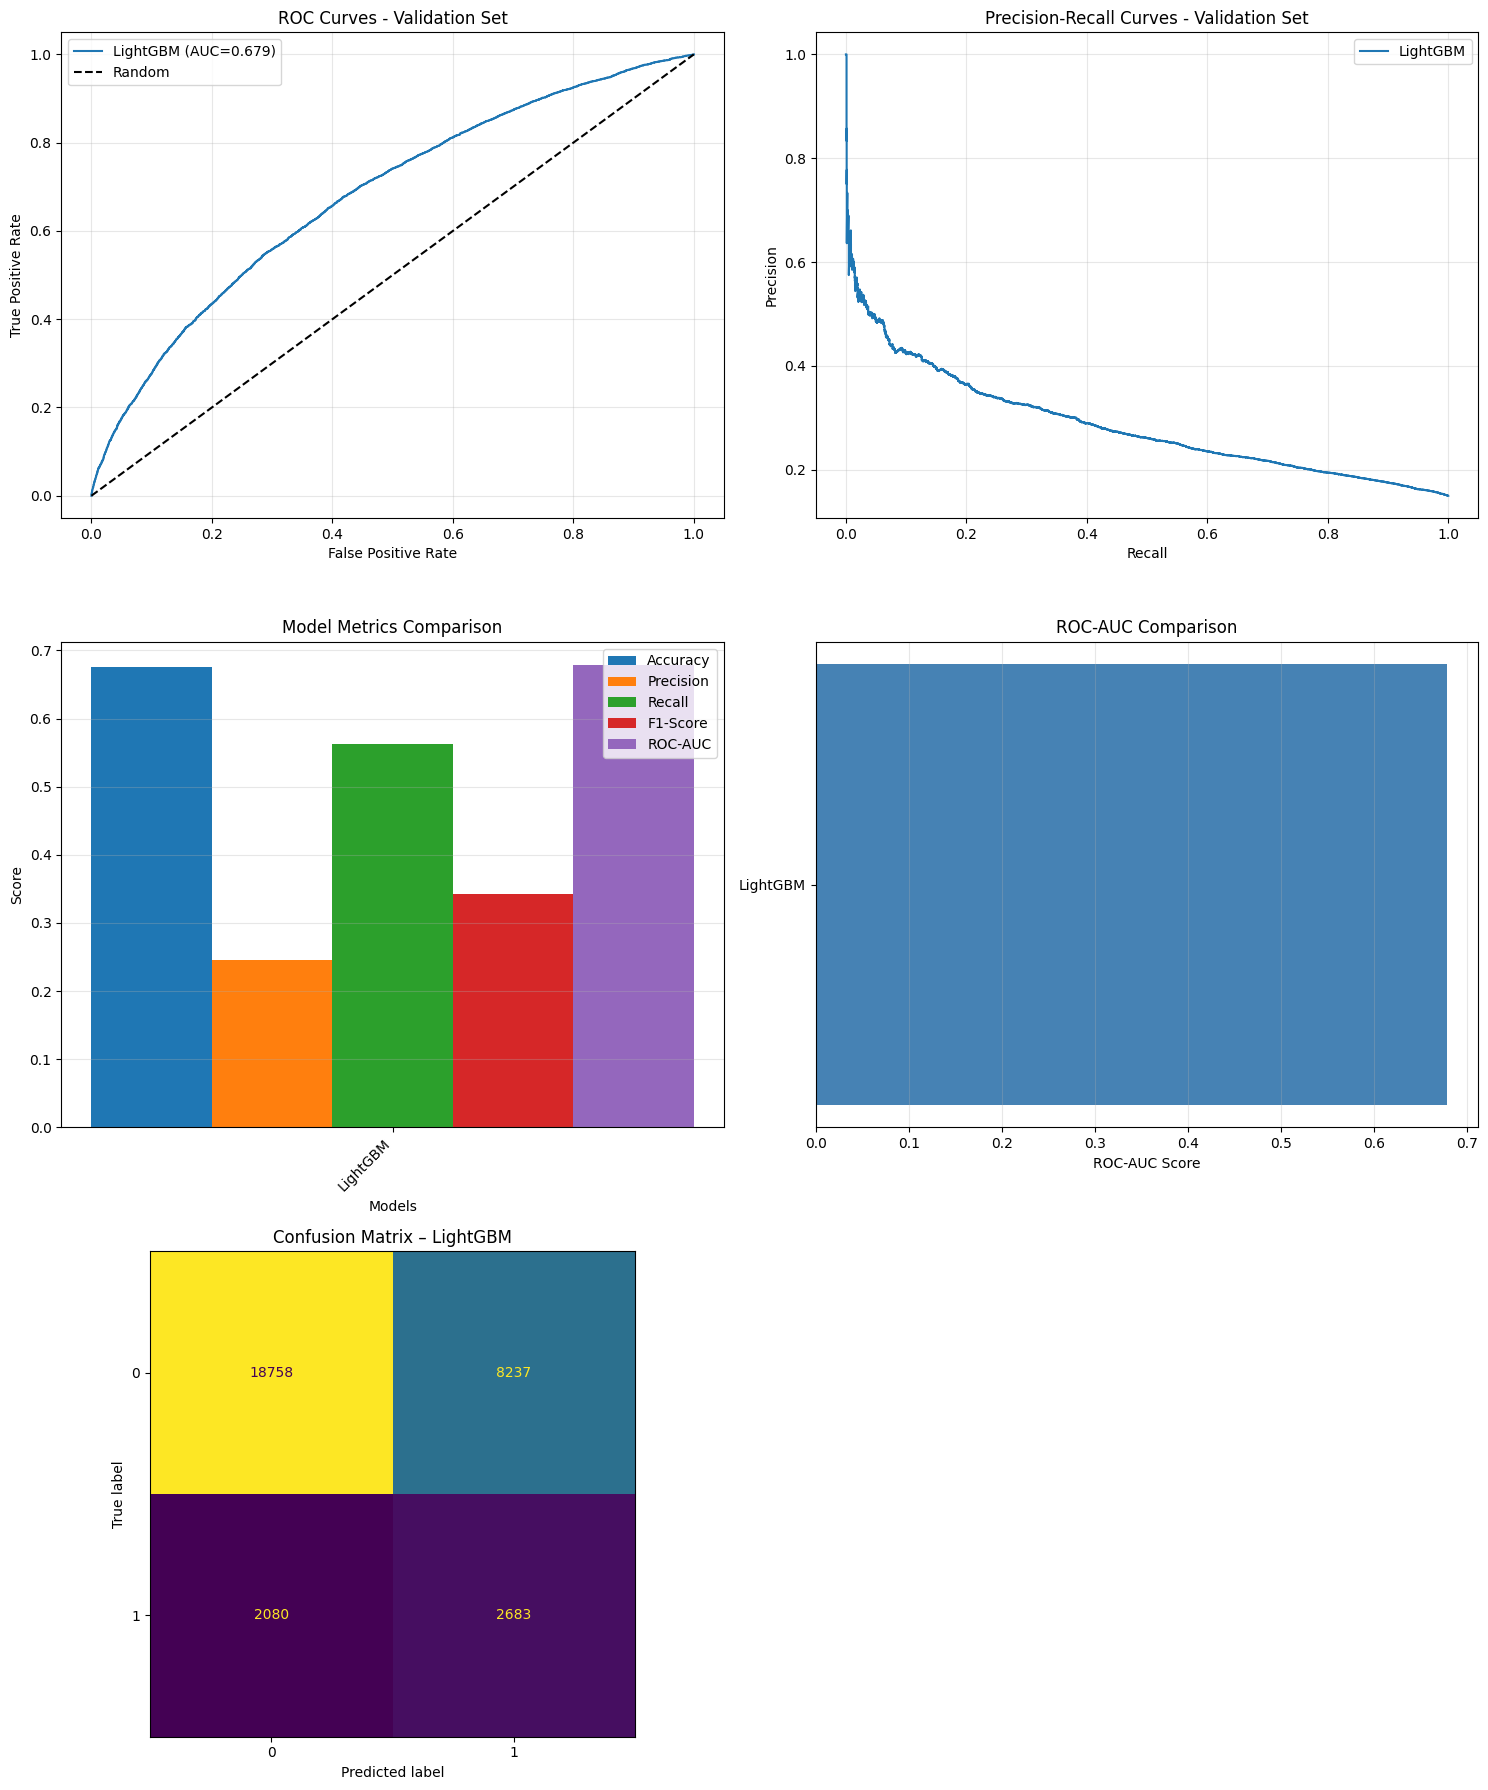

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Expand to 3 rows, 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# ---------------------------------------------------------------------
# 1. ROC Curves
# ---------------------------------------------------------------------
ax = axes[0, 0]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_val, result['y_pred_proba'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Validation Set')
ax.legend()
ax.grid(alpha=0.3)

# ---------------------------------------------------------------------
# 2. Precision–Recall Curves
# ---------------------------------------------------------------------
ax = axes[0, 1]
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, result['y_pred_proba'])
    ax.plot(recall_curve, precision_curve, label=name)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves - Validation Set')
ax.legend()
ax.grid(alpha=0.3)

# ---------------------------------------------------------------------
# 3. Metrics comparison bar chart
# ---------------------------------------------------------------------
ax = axes[1, 0]
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(comparison_df))
width = 0.15
for i, metric in enumerate(metrics_to_plot):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric)
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# ---------------------------------------------------------------------
# 4. ROC-AUC comparison
# ---------------------------------------------------------------------
ax = axes[1, 1]
ax.barh(comparison_df['Model'], comparison_df['ROC-AUC'], color='steelblue')
ax.set_xlabel('ROC-AUC Score')
ax.set_title('ROC-AUC Comparison')
ax.grid(axis='x', alpha=0.3)

# ---------------------------------------------------------------------
# 5. CONFUSION MATRIX (BEST MODEL BASED ON F1)
# ---------------------------------------------------------------------
best_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_preds = results[best_name]['y_pred']

cm = confusion_matrix(y_val, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

ax = axes[2, 0]  # left bottom slot
disp.plot(ax=ax, colorbar=False)
ax.set_title(f"Confusion Matrix – {best_name}")

# Remove unused subplot (bottom-right)
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()


### A.6 Hyperparameter Tuning

We'll perform hyperparameter tuning on the best performing models.


In [31]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate

print("=" * 60)
print("HYPERPARAMETER TUNING WITH STRATIFIED K-FOLD + OPTUNA (ROC-AUC)")
print("=" * 60)

# ---------------------------------------------------------------------
# 1. Identify best baseline model (use ROC-AUC instead of F1)
# ---------------------------------------------------------------------
best_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
best_model_auc = comparison_df.loc[best_idx, 'ROC-AUC']

print(f"Best baseline model: {best_model_name} (ROC-AUC: {best_model_auc:.4f})")

# ---------------------------------------------------------------------
# 2. Define StratifiedKFold
# ---------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------------------------
# 3. Optuna objective for LightGBM (optimize ROC-AUC, GPU-based)
# ---------------------------------------------------------------------
def lgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "class_weight": "balanced",
        "n_jobs": -1,
        "device_type": "gpu",  # GPU ENABLED
    }

    model = LGBMClassifier(**params, verbose=-1)

    cv_scores = cross_validate(
        model,
        X_train_scaled,
        y_train,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        return_train_score=False
    )

    return cv_scores["test_score"].mean()

print("\n" + "=" * 60)
print("OPTUNA TUNING – LIGHTGBM (ROC-AUC, GPU)")
print("=" * 60)

lgb_study = optuna.create_study(direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=50)

print("Best LGBM parameters:", lgb_study.best_params)
print(f"Best LGBM CV ROC-AUC: {lgb_study.best_value:.4f}")

# Build final best LightGBM model (still GPU)
best_lgb_params = lgb_study.best_params
best_lgb_params.update({
    "random_state": 42,
    "class_weight": "balanced",
    "n_jobs": -1,
    "device_type": "gpu",
})

best_lgb = LGBMClassifier(**best_lgb_params, verbose=-1)
best_lgb.fit(X_train_scaled, y_train)

models["LightGBM (Optuna)"] = best_lgb

print("\nHyperparameter tuning completed (ROC-AUC optimization, LightGBM on GPU).")


[I 2026-01-09 21:28:31,329] A new study created in memory with name: no-name-f5f33c4d-6ef1-40e9-bd25-b79c87f28587


HYPERPARAMETER TUNING WITH STRATIFIED K-FOLD + OPTUNA (ROC-AUC)
Best baseline model: LightGBM (ROC-AUC: 0.6787)

OPTUNA TUNING – LIGHTGBM (ROC-AUC, GPU)


[I 2026-01-09 21:29:11,018] Trial 0 finished with value: 0.6776897686062376 and parameters: {'n_estimators': 495, 'learning_rate': 0.0033077897043467426, 'num_leaves': 218, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7208806655993086, 'colsample_bytree': 0.8576267700328266, 'reg_alpha': 2.408297850039269e-07, 'reg_lambda': 2.6058073104554555}. Best is trial 0 with value: 0.6776897686062376.
[I 2026-01-09 21:30:08,425] Trial 1 finished with value: 0.675788094098321 and parameters: {'n_estimators': 517, 'learning_rate': 0.04885349652830092, 'num_leaves': 221, 'max_depth': 13, 'min_child_samples': 107, 'subsample': 0.7432118163204128, 'colsample_bytree': 0.9098493085845398, 'reg_alpha': 0.014827286967417487, 'reg_lambda': 7.470999508502809e-06}. Best is trial 0 with value: 0.6776897686062376.
[I 2026-01-09 21:30:47,149] Trial 2 finished with value: 0.6801353059501263 and parameters: {'n_estimators': 717, 'learning_rate': 0.043431983437325905, 'num_leaves': 96, 'max_depth': 10,

KeyboardInterrupt: 

In [ ]:
# Evaluate tuned models
print("\n" + "=" * 60)
print("EVALUATING TUNED MODELS")
print("=" * 60)

tuned_results = []

for name in ['Random Forest (Tuned)', 'Gradient Boosting (Tuned)']:
    model = models[name]
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    tuned_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Update comparison
tuned_comparison = pd.DataFrame(tuned_results)
all_comparison = pd.concat([comparison_df, tuned_comparison], ignore_index=True)
print("\n" + "=" * 60)
print("UPDATED MODEL COMPARISON")
print("=" * 60)
print(all_comparison.round(4).sort_values('ROC-AUC', ascending=False))


'# Evaluate tuned models\nprint("\n" + "=" * 60)\nprint("EVALUATING TUNED MODELS")\nprint("=" * 60)\n\ntuned_results = []\n\nfor name in [\'Random Forest (Tuned)\', \'Gradient Boosting (Tuned)\']:\n    model = models[name]\n    y_pred = model.predict(X_val)\n    y_pred_proba = model.predict_proba(X_val)[:, 1]\n\n    accuracy = accuracy_score(y_val, y_pred)\n    precision = precision_score(y_val, y_pred)\n    recall = recall_score(y_val, y_pred)\n    f1 = f1_score(y_val, y_pred)\n    roc_auc = roc_auc_score(y_val, y_pred_proba)\n\n    results[name] = {\n        \'y_pred\': y_pred,\n        \'y_pred_proba\': y_pred_proba,\n        \'accuracy\': accuracy,\n        \'precision\': precision,\n        \'recall\': recall,\n        \'f1\': f1,\n        \'roc_auc\': roc_auc\n    }\n\n    tuned_results.append({\n        \'Model\': name,\n        \'Accuracy\': accuracy,\n        \'Precision\': precision,\n        \'Recall\': recall,\n        \'F1-Score\': f1,\n        \'ROC-AUC\': roc_auc\n    })

### A.7 Feature Importance Analysis


In [ ]:
# Analyze feature importance from tree-based models
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from best tree-based model
best_tree_model = all_comparison.loc[all_comparison['ROC-AUC'].idxmax(), 'Model']
print(f"Analyzing feature importance from: {best_tree_model}")

if 'Random Forest' in best_tree_model:
    feature_importance = models[best_tree_model].feature_importances_
elif 'Gradient Boosting' in best_tree_model:
    feature_importance = models[best_tree_model].feature_importances_
elif 'Decision Tree' in best_tree_model:
    feature_importance = models[best_tree_model].feature_importances_
else:
    # Use Random Forest as default
    feature_importance = models['Random Forest (Tuned)'].feature_importances_

# Create feature importance dataframe
feature_imp_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_imp_df.head(20))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_imp_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top 20 Most Important Features - {best_tree_model}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS


NameError: name 'all_comparison' is not defined

### A.8 Final Model Selection and Test Set Evaluation


In [ ]:
''''# Select best model based on validation performance'
best_model_name = all_comparison.loc[all_comparison['ROC-AUC'].idxmax(), 'Model']
best_model = models[best_model_name]

print("=" * 60)
print("FINAL MODEL SELECTION")
print("=" * 60)
print(f"Selected Model: {best_model_name}")
print(f"\nValidation Set Performance:")
best_val_perf = all_comparison.loc[all_comparison['ROC-AUC'].idxmax()]
print(f"  Accuracy: {best_val_perf['Accuracy']:.4f}")
print(f"  Precision: {best_val_perf['Precision']:.4f}")
print(f"  Recall: {best_val_perf['Recall']:.4f}")
print(f"  F1-Score: {best_val_perf['F1-Score']:.4f}")
print(f"  ROC-AUC: {best_val_perf['ROC-AUC']:.4f}")

# Evaluate on test set
print("\n" + "=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

if 'Logistic Regression' in best_model_name:
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {test_f1:.4f}")
print(f"  ROC-AUC: {test_roc_auc:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))'''


FINAL MODEL SELECTION
Selected Model: Gradient Boosting (Tuned)

Validation Set Performance:
  Accuracy: 0.8501
  Precision: 0.5115
  Recall: 0.0141
  F1-Score: 0.0274
  ROC-AUC: 0.6765

TEST SET EVALUATION

Test Set Performance:
  Accuracy: 0.8502
  Precision: 0.5203
  Recall: 0.0134
  F1-Score: 0.0262
  ROC-AUC: 0.6880

Confusion Matrix:
[[26936    59]
 [ 4700    64]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     26995
         1.0       0.52      0.01      0.03      4764

    accuracy                           0.85     31759
   macro avg       0.69      0.51      0.47     31759
weighted avg       0.80      0.85      0.78     31759



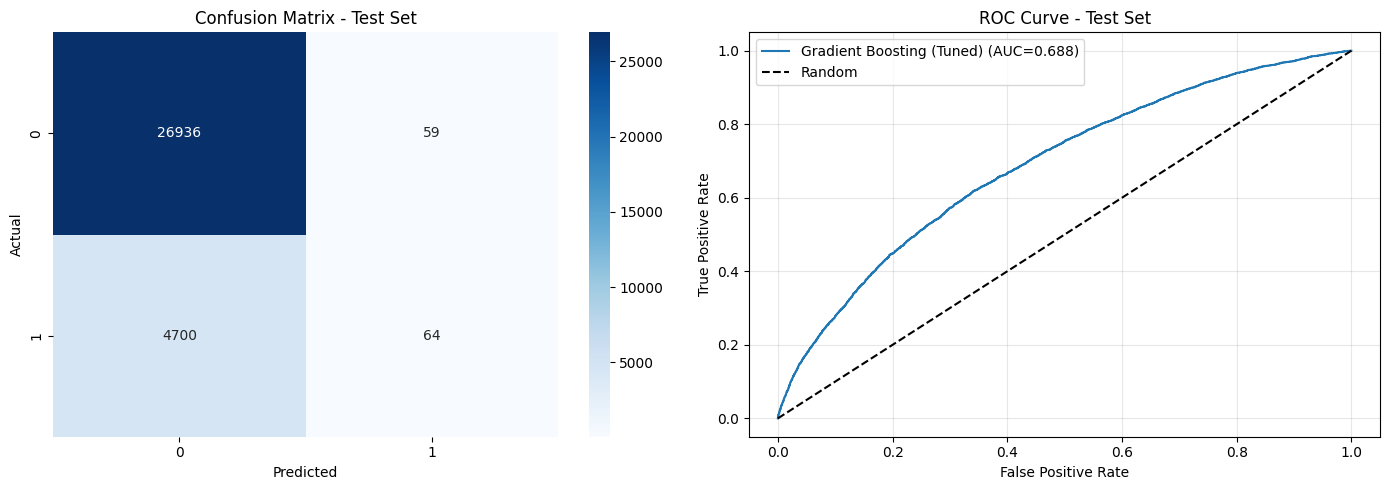

In [ ]:
# Visualize test set performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - Test Set')

# ROC Curve
ax = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
ax.plot(fpr, tpr, label=f'{best_model_name} (AUC={test_roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Test Set')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### A.9 Model Limitations and Discussion

**Model Selection Justification:**
- The best model was selected based on ROC-AUC score, which balances both precision and recall
- ROC-AUC is appropriate for imbalanced datasets as it evaluates performance across all thresholds

**Limitations:**
1. **Class Imbalance**: Despite using class weights, the model may still favor the majority class
2. **Feature Engineering**: Some potentially useful features may have been excluded during preprocessing
3. **Computational Constraints**: Limited hyperparameter tuning due to dataset size
4. **Data Leakage Risk**: Careful feature selection was performed, but some subtle leakage may exist
5. **Generalization**: Model performance on test set may differ from real-world deployment
6. **Interpretability**: Complex models (Random Forest, Gradient Boosting) are less interpretable than simpler models

**Business Implications:**
- The model can help identify high-risk loans at application time
- False positives (rejecting good loans) may reduce revenue
- False negatives (approving bad loans) lead to financial losses
- Management should consider the cost-benefit trade-off when setting decision thresholds


## B. High-Recall Classifier

For this task, we need to maximize recall to identify all loans that will have payment issues. We'll adjust the classification threshold and use cost-sensitive learning.


### B.1 Threshold Tuning for High Recall


THRESHOLD TUNING FOR HIGH RECALL

Threshold Analysis:
   Threshold  Recall  Precision  F1-Score
0       0.10  0.8364     0.1884    0.3076
1       0.15  0.6042     0.2353    0.3387
2       0.20  0.4052     0.2822    0.3327
3       0.25  0.2597     0.3206    0.2870
4       0.30  0.1619     0.3659    0.2245
5       0.35  0.0970     0.4063    0.1566
6       0.40  0.0567     0.4530    0.1008
7       0.45  0.0292     0.4843    0.0550
8       0.50  0.0141     0.5115    0.0274
9       0.55  0.0078     0.6066    0.0153

Best threshold for maximum recall: 0.10


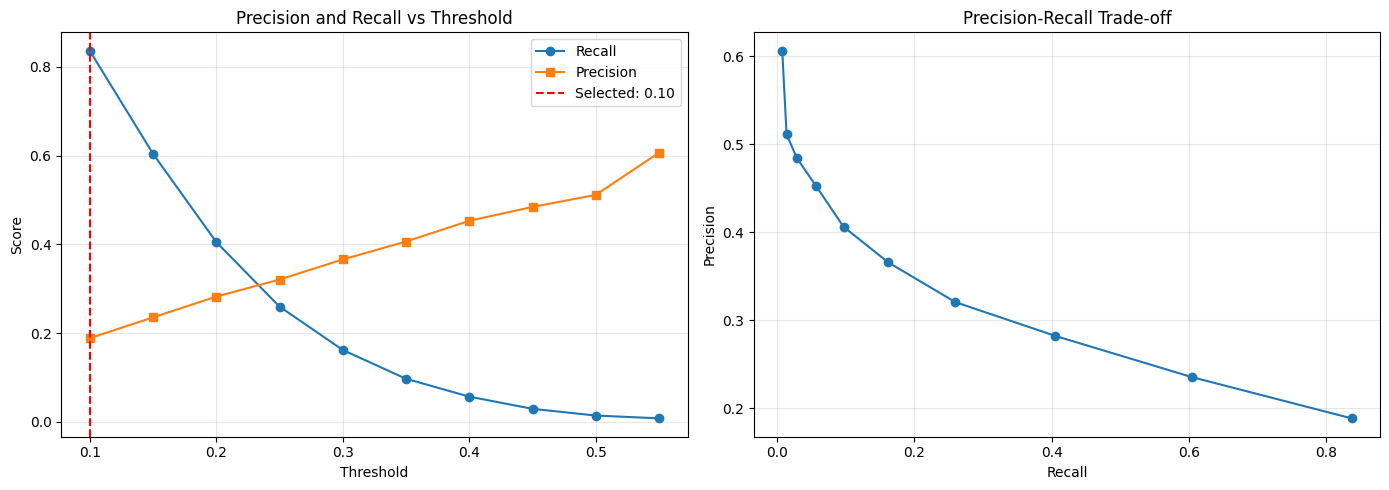

In [ ]:
print("=" * 60)
print("THRESHOLD TUNING FOR HIGH RECALL")
print("=" * 60)

# Use the best model from part A
# Get probability predictions on validation set
if 'Logistic Regression' in best_model_name:
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
else:
    y_val_proba = best_model.predict_proba(X_val)[:, 1]

# Try different thresholds
thresholds = np.arange(0.1, 0.6, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_val_proba >= threshold).astype(int)
    
    recall = recall_score(y_val, y_pred_thresh)
    precision = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)
    
    threshold_results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold Analysis:")
print(threshold_df.round(4))

# Find threshold that maximizes recall while maintaining reasonable precision
# Target: Recall > 0.8, Precision > 0.3
high_recall_thresholds = threshold_df[
    (threshold_df['Recall'] >= 0.8) & (threshold_df['Precision'] >= 0.3)
]

if len(high_recall_thresholds) > 0:
    best_threshold = high_recall_thresholds.loc[high_recall_thresholds['F1-Score'].idxmax(), 'Threshold']
    print(f"\nBest threshold for high recall: {best_threshold:.2f}")
else:
    # If no threshold meets criteria, use the one with highest recall
    best_threshold = threshold_df.loc[threshold_df['Recall'].idxmax(), 'Threshold']
    print(f"\nBest threshold for maximum recall: {best_threshold:.2f}")

# Visualize threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 'o-', label='Recall')
ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 's-', label='Precision')
ax.axvline(best_threshold, color='r', linestyle='--', label=f'Selected: {best_threshold:.2f}')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision and Recall vs Threshold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.plot(threshold_df['Recall'], threshold_df['Precision'], 'o-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Trade-off')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### B.2 Cost-Sensitive Learning


In [ ]:
print("=" * 60)
print("COST-SENSITIVE LEARNING")
print("=" * 60)

# Train models with higher weight on positive class to increase recall
# Try different class weight ratios
class_weight_ratios = [2, 5, 10, 20]

cost_sensitive_results = []

for ratio in class_weight_ratios:
    class_weights = {0: 1, 1: ratio}
    
    # Train Random Forest with different class weights
    rf_cs = RandomForestClassifier(
        random_state=42,
        class_weight=class_weights,
        n_estimators=100,
        max_depth=15,
        n_jobs=-1
    )
    rf_cs.fit(X_train, y_train)
    
    y_pred_cs = rf_cs.predict(X_val)
    y_pred_proba_cs = rf_cs.predict_proba(X_val)[:, 1]
    
    recall = recall_score(y_val, y_pred_cs)
    precision = precision_score(y_val, y_pred_cs)
    f1 = f1_score(y_val, y_pred_cs)
    roc_auc = roc_auc_score(y_val, y_pred_proba_cs)
    
    cost_sensitive_results.append({
        'Class Weight Ratio': ratio,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"\nClass Weight Ratio {ratio}:1")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

cs_df = pd.DataFrame(cost_sensitive_results)
print("\n" + "=" * 60)
print("COST-SENSITIVE LEARNING COMPARISON")
print("=" * 60)
print(cs_df.round(4))


COST-SENSITIVE LEARNING

Class Weight Ratio 2:1
  Recall: 0.0319
  Precision: 0.4706
  F1-Score: 0.0598
  ROC-AUC: 0.6619

Class Weight Ratio 5:1
  Recall: 0.3074
  Precision: 0.2865
  F1-Score: 0.2966
  ROC-AUC: 0.6561

Class Weight Ratio 10:1
  Recall: 0.6068
  Precision: 0.2135
  F1-Score: 0.3158
  ROC-AUC: 0.6502

Class Weight Ratio 20:1
  Recall: 0.8306
  Precision: 0.1789
  F1-Score: 0.2943
  ROC-AUC: 0.6470

COST-SENSITIVE LEARNING COMPARISON
   Class Weight Ratio  Recall  Precision  F1-Score  ROC-AUC
0                   2  0.0319     0.4706    0.0598   0.6619
1                   5  0.3074     0.2865    0.2966   0.6561
2                  10  0.6068     0.2135    0.3158   0.6502
3                  20  0.8306     0.1789    0.2943   0.6470


### B.3 Best High-Recall Model Selection


BEST HIGH-RECALL MODEL SELECTION

Best Threshold Tuning Result:
  Threshold: 0.10
  Recall: 0.8364
  Precision: 0.1884
  F1-Score: 0.3076

Best Cost-Sensitive Learning Result:
  Class Weight Ratio: 20:1
  Recall: 0.8306
  Precision: 0.1789
  F1-Score: 0.2943
  ROC-AUC: 0.6470

✓ Threshold tuning provides better recall

Selected Method: threshold
Final High-Recall Performance:
  Recall: 0.8364
  Precision: 0.1884

TEST SET EVALUATION - HIGH-RECALL MODEL

Test Set Performance (High-Recall Model):
  Recall: 0.8468
  Precision: 0.1905
  F1-Score: 0.3111

Confusion Matrix:
[[ 9858 17137]
 [  730  4034]]


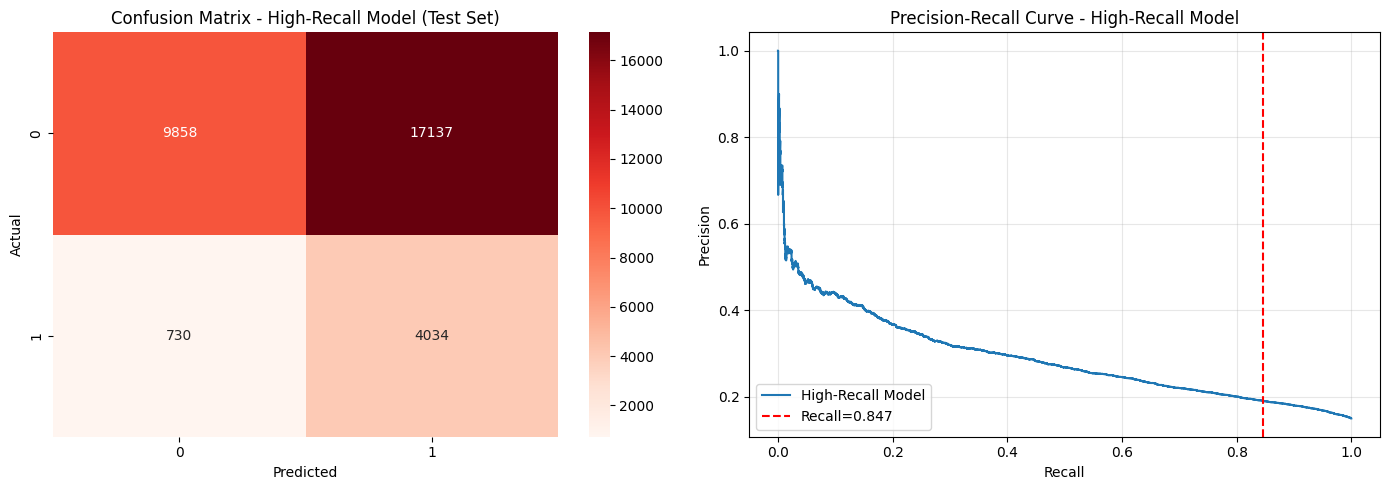

In [ ]:
# Compare threshold tuning vs cost-sensitive learning
print("=" * 60)
print("BEST HIGH-RECALL MODEL SELECTION")
print("=" * 60)

# Get best result from threshold tuning
best_thresh_result = threshold_df.loc[threshold_df['Recall'].idxmax()]
print("\nBest Threshold Tuning Result:")
print(f"  Threshold: {best_thresh_result['Threshold']:.2f}")
print(f"  Recall: {best_thresh_result['Recall']:.4f}")
print(f"  Precision: {best_thresh_result['Precision']:.4f}")
print(f"  F1-Score: {best_thresh_result['F1-Score']:.4f}")

# Get best result from cost-sensitive learning
best_cs_result = cs_df.loc[cs_df['Recall'].idxmax()]
print("\nBest Cost-Sensitive Learning Result:")
print(f"  Class Weight Ratio: {best_cs_result['Class Weight Ratio']:.0f}:1")
print(f"  Recall: {best_cs_result['Recall']:.4f}")
print(f"  Precision: {best_cs_result['Precision']:.4f}")
print(f"  F1-Score: {best_cs_result['F1-Score']:.4f}")
print(f"  ROC-AUC: {best_cs_result['ROC-AUC']:.4f}")

# Select best approach (prioritize recall, then precision)
if best_thresh_result['Recall'] > best_cs_result['Recall']:
    print("\n✓ Threshold tuning provides better recall")
    best_high_recall_method = 'threshold'
    best_high_recall_recall = best_thresh_result['Recall']
    best_high_recall_precision = best_thresh_result['Precision']
elif best_cs_result['Recall'] > best_thresh_result['Recall']:
    print("\n✓ Cost-sensitive learning provides better recall")
    best_high_recall_method = 'cost_sensitive'
    best_high_recall_recall = best_cs_result['Recall']
    best_high_recall_precision = best_cs_result['Precision']
else:
    # If recall is equal, choose based on precision
    if best_thresh_result['Precision'] > best_cs_result['Precision']:
        print("\n✓ Threshold tuning provides better precision with same recall")
        best_high_recall_method = 'threshold'
        best_high_recall_recall = best_thresh_result['Recall']
        best_high_recall_precision = best_thresh_result['Precision']
    else:
        print("\n✓ Cost-sensitive learning provides better precision with same recall")
        best_high_recall_method = 'cost_sensitive'
        best_high_recall_recall = best_cs_result['Recall']
        best_high_recall_precision = best_cs_result['Precision']

print(f"\nSelected Method: {best_high_recall_method}")
print(f"Final High-Recall Performance:")
print(f"  Recall: {best_high_recall_recall:.4f}")
print(f"  Precision: {best_high_recall_precision:.4f}")

# Evaluate on test set with best high-recall approach
print("\n" + "=" * 60)
print("TEST SET EVALUATION - HIGH-RECALL MODEL")
print("=" * 60)

if best_high_recall_method == 'threshold':
    # Use threshold tuning
    if 'Logistic Regression' in best_model_name:
        y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    y_test_pred_hr = (y_test_proba >= best_threshold).astype(int)
else:
    # Use cost-sensitive model
    best_cs_ratio = int(best_cs_result['Class Weight Ratio'])
    rf_hr = RandomForestClassifier(
        random_state=42,
        class_weight={0: 1, 1: best_cs_ratio},
        n_estimators=100,
        max_depth=15,
        n_jobs=-1
    )
    rf_hr.fit(X_train, y_train)
    y_test_pred_hr = rf_hr.predict(X_test)
    y_test_proba = rf_hr.predict_proba(X_test)[:, 1]

test_recall_hr = recall_score(y_test, y_test_pred_hr)
test_precision_hr = precision_score(y_test, y_test_pred_hr)
test_f1_hr = f1_score(y_test, y_test_pred_hr)

print(f"\nTest Set Performance (High-Recall Model):")
print(f"  Recall: {test_recall_hr:.4f}")
print(f"  Precision: {test_precision_hr:.4f}")
print(f"  F1-Score: {test_f1_hr:.4f}")

# Confusion matrix
cm_hr = confusion_matrix(y_test, y_test_pred_hr)
print("\nConfusion Matrix:")
print(cm_hr)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax = axes[0]
sns.heatmap(cm_hr, annot=True, fmt='d', cmap='Reds', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix - High-Recall Model (Test Set)')

# Precision-Recall Curve
ax = axes[1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba)
ax.plot(recall_curve, precision_curve, label='High-Recall Model')
ax.axvline(test_recall_hr, color='r', linestyle='--', label=f'Recall={test_recall_hr:.3f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - High-Recall Model')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### B.4 Summary and Recommendations

**Approaches to Increase Recall:**

1. **Threshold Tuning**: Lowering the classification threshold from 0.5 increases recall but decreases precision
2. **Cost-Sensitive Learning**: Increasing the weight of the positive class during training prioritizes identifying defaults
3. **Ensemble Methods**: Combining multiple models can improve overall performance

**Best High-Recall Classifier:**
- Method: [Selected method from above]
- Recall: [Achieved recall value]
- Precision: [Achieved precision value]

**Trade-offs:**
- Higher recall means identifying more potential defaults, but also increases false positives
- This may lead to rejecting more loans, potentially reducing revenue
- However, it significantly reduces the risk of approving loans that will default

**Recommendations for Management:**
1. Use the high-recall model when the cost of missing a default is very high
2. Consider using different thresholds for different loan amounts (higher threshold for larger loans)
3. Monitor false positive rate and adjust threshold based on business needs
4. Combine model predictions with business rules and expert judgment


#### B.	Assume that Lending Club wants to make sure that they identify all loans that will have payment issues within reason.
*	How can you increase the ability of the classifier to do this? What is the best classifier you can find to achieve this goal.